<a href="https://colab.research.google.com/github/cabamarcos/Captcha_recognition/blob/main/IAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

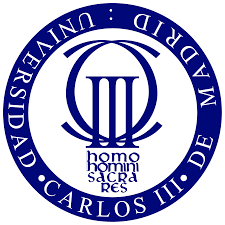

# PRÁCTICA FINAL: INTELIGENCIA ARTIFICIAL EN LAS ORGANIZACIONES

Pablo Hidalgo: 100451225.
Pablo Brasero: 100451247.
Miguel Castuera: 100451285.
Marcos Caballero: 100451047.   



# Introducción

En un mundo cada vez más digitalizado, la protección de datos y la seguridad en línea son imperativos. Sin embargo, el uso generalizado de CAPTCHAs (Completely Automated Public Turing test to tell Computers and Humans Apart) ha planteado un desafío no solo para los usuarios legítimos, sino también para los sistemas de inteligencia artificial. Los CAPTCHAs son desafíos diseñados para distinguir a los humanos de los bots, lo que dificulta la automatización de tareas en línea. El proyecto de inteligencia artificial que presentamos aquí se centra en el desarrollo de técnicas avanzadas para reconocer y superar CAPTCHAs de manera efectiva.

Este proyecto de inteligencia artificial aprovechará una variedad de técnicas y enfoques para resolver CAPTCHAs de manera efectiva. Desde el procesamiento de imágenes y el aprendizaje profundo hasta la clasificación de patrones y la segmentación, nuestro objetivo es desarrollar un sistema capaz de superar una amplia gama de CAPTCHAs con una alta tasa de éxito.

El éxito de este proyecto no solo repercutirá en la automatización de tareas en línea, sino que también ofrecerá una oportunidad para mejorar la seguridad y la protección de datos en la era digital. A medida que avanzamos hacia un mundo más interconectado, la capacidad de superar CAPTCHAs de manera efectiva se convierte en un factor clave en la evolución de la inteligencia artificial y la ciberseguridad. Este proyecto promete ser una contribución valiosa en la búsqueda de soluciones innovadoras para desafíos en constante evolución.

# Importación de las herramientas necesarias

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from collections import Counter
from pathlib import Path
import time


from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow


import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer

# Análisis exploratorio de los datos

Según el creador de la publicación en kaggle, el dataset contiene palabras de 5 letras cada una.
Las palabras tienen ruido (blur y lineas).
Las imagenes PNG contienen 200x50 pixeles

Primero vamos a ver la naturaleza de los datos.
Para ello vamos a mostrarlos por pantalla.

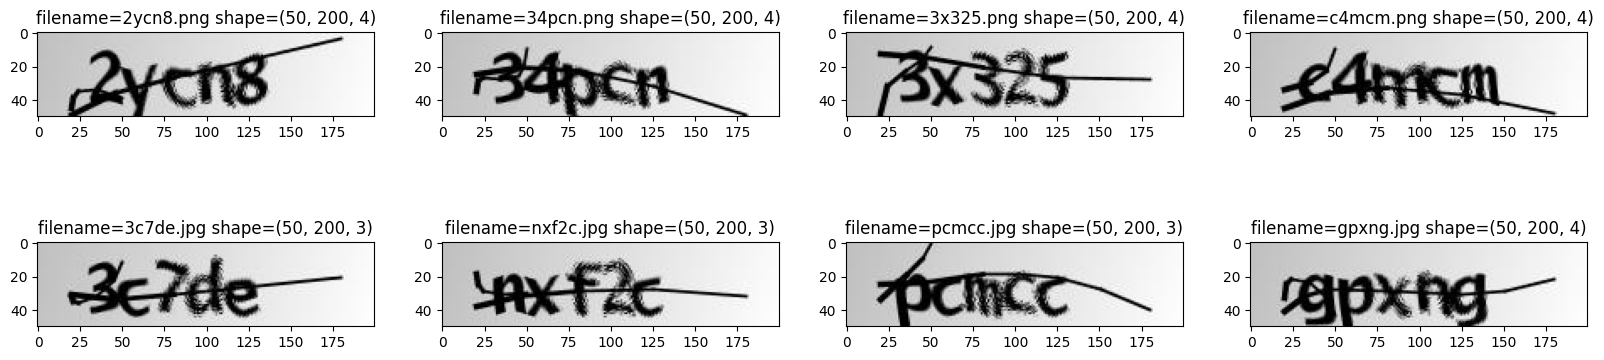

In [2]:
img_2ycn8 = mpimg.imread('2ycn8.png')
img_34pcn = mpimg.imread('34pcn.png')
img_3x325 = mpimg.imread('3x325.png')
img_c4mcm = mpimg.imread('c4mcm.png')
img_3c7de = mpimg.imread('3c7de.jpg')
img_nxf2c = mpimg.imread('nxf2c.jpg')
img_pcmcc = mpimg.imread('pcmcc.jpg')
img_gpxng = mpimg.imread('gpxng.png')
samples = {'2ycn8.png':img_2ycn8, '34pcn.png':img_34pcn, '3x325.png':img_3x325, 'c4mcm.png':img_c4mcm,
           '3c7de.jpg':img_3c7de, 'nxf2c.jpg':img_nxf2c, 'pcmcc.jpg':img_pcmcc, 'gpxng.jpg':img_gpxng}

fig=plt.figure(figsize=(20, 5))
pos = 1
for filename, img in samples.items():
    fig.add_subplot(2, 4, pos)
    pos = pos+1
    plt.imshow(img)
    plt.title('filename='+filename+' shape='+str(img.shape))
plt.show()

Como podemos ver, los nombres de las imágenes obviamente coincide con los caracteres de las imágenes.

Cabe destacar que al ver las imágenes, hemos notado que los numeros y letras se repiten notablemente, por lo que vamos a hacer un análisis para ver que caracteres se están utilizando, ya que nos puede ayudar en el futuro entrenamiento.

In [3]:
# Especifica la ruta a la carpeta que contiene las imágenes
image_folder = Path('/content/')

# Obtiene la lista de imágenes en la carpeta
images = list(image_folder.glob("*.png")) + list(image_folder.glob("*.jpg"))

# Store all the characters in a set
characters = set()

# Store all the labels in a set
labels = set()

# Create a list of dictionaries to store the image-label pair info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]
    # 2. Store the length of this captcha
    captcha_length = len(label)
    # 3. Store the image-label pair info
    dataset.append({"img_path": str(img_path), "label": label})
    # 4. Store the characters present
    characters.update(set(label))
    # 5. Store the labels
    labels.add(label)

# Convert the list of dictionaries into a DataFrame
dataset = pd.DataFrame(dataset)

print("Number of images found:", len(images))
print("Number of labels found:", len(labels))
print("Number of unique characters:", len(characters))
print("Characters present:", characters)


Number of images found: 1019
Number of labels found: 1019
Number of unique characters: 21
Characters present: {'8', 'x', 'j', 'g', 'p', '5', '2', 'b', '3', 'f', 'y', 'w', 'n', '6', '4', '.', 'd', 'm', 'e', '7', 'c'}


Como podemos ver, solo contiene 19 caracteres distintos, en vez de los 36 posibles si combinamos números y letras si excluimos la ñ, por lo que nuestro espacio de trabajo y búsqueda se ha reducido considerablemente.

Ahora vamos a ver con cuanta frecuencia se repite cada caracter

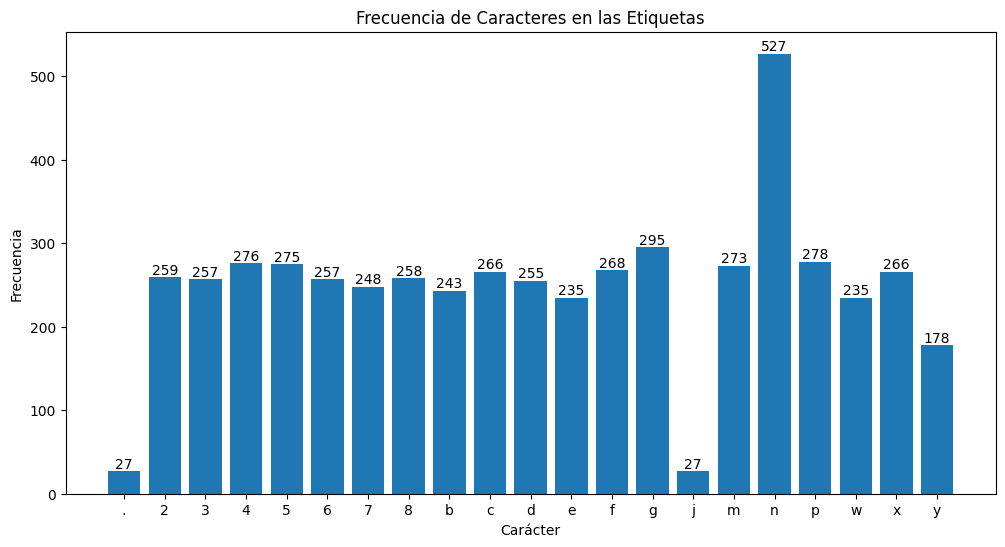

In [4]:
# Calcula la frecuencia de cada carácter
character_counts = Counter("".join(dataset["label"]))

# Convierte los resultados en dos listas separadas para plotear
characters = list(character_counts.keys())
counts = list(character_counts.values())

# Ordena los caracteres alfabéticamente
characters, counts = zip(*sorted(zip(characters, counts)))

# Crea la gráfica de barras
plt.figure(figsize=(12, 6))
plt.bar(characters, counts)

# Agrega etiquetas con el número exacto en cada barra
for i in range(len(characters)):
    plt.text(characters[i], counts[i], str(counts[i]), ha='center', va='bottom')

plt.xlabel("Carácter")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de Caracteres en las Etiquetas")
plt.show()

Podemos ver que los datos son balanceados menos la n, la cual tiene el doble de datos que los demás. Aplicaremos las medidas necesarias para que los datos estén balanceados.

#Estrategia

## Primeros pasos

In [5]:
np.random.seed(2)
sns.set(style='white', context='notebook', palette='deep')

### Análisis visual de operaciones en los datos

En este apartado, vamos a intentar mostrar lo que vamos a realizar en el siguiente apartado.

Según podemos ver, nuestras imágenes tienen una linea que corta a la mayoría de caracteres, además, vemos que algunos caracteres están algo difuminados y distorsionados. Vamos a intentar eliminar la línea mediante operaciones en la imagen.

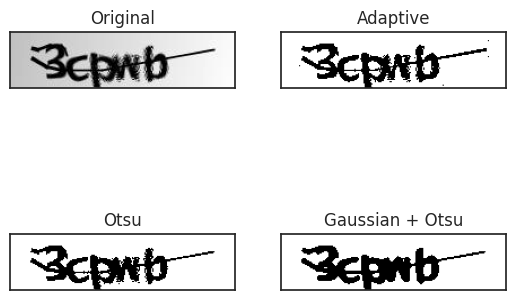

In [6]:
import cv2
import matplotlib.pyplot as plt

# Leer la imagen en escala de grises
image = cv2.imread('3cpwb.png', 0)

# Umbral adaptativo
adaptive_threshold = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 17, 2)

# Umbral de Otsu
_, otsu_threshold = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Umbral de Otsu con desenfoque Gaussiano
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
_, gaussian_otsu_threshold = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Gráficos
titles = ['Original', 'Adaptive', 'Otsu', 'Gaussian + Otsu']
images = [image, adaptive_threshold, otsu_threshold, gaussian_otsu_threshold]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.show()


Como podemos ver, las operaciones consiguen borrar el difuminado, pero no conseguimos borrar las lineas.

Vamos a probar otras operaciones, de forma que consiga borrar las líneas más finas.

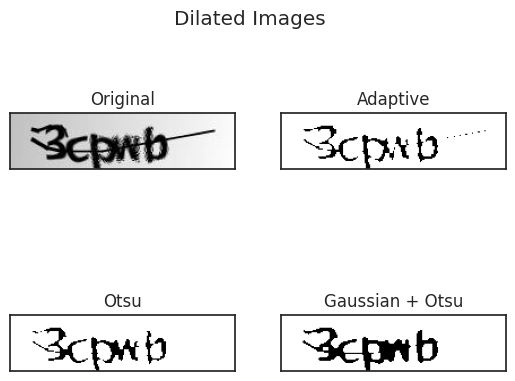

In [7]:
kernel = np.ones((3, 3), np.uint8)

# Aplicar dilatación a las imágenes umbralizadas
dilated_adaptive = cv2.dilate(adaptive_threshold, kernel, iterations=1)
dilated_otsu = cv2.dilate(otsu_threshold, kernel, iterations=1)
dilated_gaussian_otsu = cv2.dilate(gaussian_otsu_threshold, kernel, iterations=1)

# Gráficos
titles = ['Original', 'Adaptive', 'Otsu', 'Gaussian + Otsu']
images = [image, dilated_adaptive, dilated_otsu, dilated_gaussian_otsu]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.suptitle('Dilated Images')
plt.show()

Como podemos ver en este ejemplo, la linea se ha borrado casi por completo y las letras no son del todo ilegibles.

Vamos a ver si con otras operaciónes podemos generar una imagen con los caracteres algo más legibles.

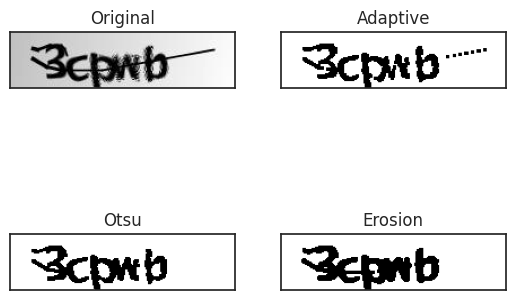

In [8]:
erosion_adaptive = cv2.erode(dilated_adaptive, kernel, iterations=1)
erosion_otsu = cv2.erode(dilated_otsu, kernel, iterations=1)
erosion_gaussian_otsu = cv2.erode(dilated_gaussian_otsu, kernel, iterations=1)

# Gráficos
titles = ['Original', 'Adaptive', 'Otsu', 'Gaussian + Otsu']
images = [image, erosion_adaptive, erosion_otsu, erosion_gaussian_otsu]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.title('Erosion')
plt.show()

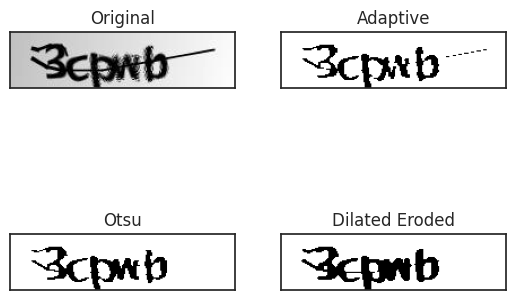

In [9]:
# Crear un nuevo kernel para la segunda dilatación
kernel2 = np.ones((3, 1), np.uint8)

# Aplicar una segunda dilatación a las imágenes erosionadas
dilated_erosion_adaptive = cv2.dilate(erosion_adaptive, kernel2, iterations=1)
dilated_erosion_otsu = cv2.dilate(erosion_otsu, kernel2, iterations=1)
dilated_erosion_gaussian_otsu = cv2.dilate(erosion_gaussian_otsu, kernel2, iterations=1)

# Gráficos
titles = ['Original', 'Adaptive', 'Otsu', 'Gaussian + Otsu']
images = [image, dilated_erosion_adaptive, dilated_erosion_otsu, dilated_erosion_gaussian_otsu]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.title('Dilated Eroded')
plt.show()

En este últumo ejemplo, podemos ver unas letras mucho más legibles, en la que la linea se ve mucho menos.

Gracias a estos ejemplos, podemos ver cómo mediante operaciones aplicadas a las imágenes, se pueden "limpiar" de forma que sea mucho más legible, eliminando las difuminaciones y suavizando las líneas.

### Aplicación de filtros en las imágenes

Vamos a aplicar lo mostrado en el apartado anterior, en todas y cada una de las imágenes que tenemos.

Primero vamos a definir las partes de las imágenes que no nos contienen datos en las imágenes, para luego aplicar el relleno de imagen con cv2

In [10]:
# Definir un kernel de convolución de 3x1 con valores enteros sin signo
kernel = np.ones((3, 1), np.uint8)

# Definir el tipo de borde a utilizar
borderType = cv2.BORDER_CONSTANT

# Función para aplicar relleno a una imagen
def pad(src):
    # Calcular la cantidad de píxeles de relleno para la parte superior e inferior
    top = int(0.05 * src.shape[0])  # El 5% de la altura de la imagen
    bottom = top

    # Calcular la cantidad de píxeles de relleno para la parte izquierda y derecha
    left = int(0.15 * src.shape[1])  # El 15% de la anchura de la imagen
    right = left

    # Aplicar el relleno a la imagen de origen utilizando cv2.copyMakeBorder
    des = cv2.copyMakeBorder(src, top, bottom, left + 1, right, borderType, None, 255)

    # Invertir los colores de la imagen utilizando cv2.bitwise_not
    return cv2.bitwise_not(des)

Vamos a ver dos ejemplos de las operaciones aplicadas a las imágenes antes de dividirla por caracteres

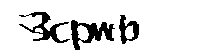

In [11]:
im = cv2.imread(str('3cpwb.png'), 0)


_, otsu_threshold2 = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
kernel = np.ones((3, 3), np.uint8)
dilated_otsu2 = cv2.dilate(otsu_threshold2, kernel, iterations=1)
erosion_otsu2 = cv2.erode(dilated_otsu2, kernel, iterations=1)
kernel2 = np.ones((3, 1), np.uint8)
dilated_erosion_otsu2 = cv2.dilate(erosion_otsu2, kernel2, iterations=1)


cv2_imshow(dilated_erosion_otsu2)


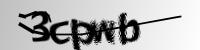

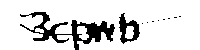

In [12]:
im = cv2.imread(str('3cpwb.png'), 0)
cv2_imshow(im)
# Aplicar un umbral adaptativo a la imagen utilizando el método GAUSSIAN_C
threshold = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 5)

# Dilatar la imagen umbralizada utilizando un kernel definido en algún lugar anterior del código
erosion = cv2.dilate(threshold, kernel, iterations=1)

cv2_imshow(erosion)


Podemos observar que no hay gran diferencia entre las dos imágenes, pero vamos a decantarnos por la segunda opción, ya que podemos ver, que difumina mejor las líneas, por lo que creemos que generará un mejor modelo.

La siguiente parte del código, procesa una lista de imágenes utilizando la biblioteca OpenCV para aplicar umbralización adaptativa, dilatación y otras operaciones vistas en el apartado anterior, y luego recopila las imágenes resultantes en una lista x y sus etiquetas en una lista y.

In [13]:
images = list(image_folder.glob("*.png")) + list(image_folder.glob("*.jpg"))
x = []  # Lista para almacenar las imágenes procesadas
y = []  # Lista para almacenar las etiquetas correspondientes

# Iterar a través de la lista de imágenes
for image in images:
    # Cargar la imagen en escala de grises (canal único)
    im = cv2.imread(str(image), 0)

    # Aplicar un umbral adaptativo a la imagen utilizando el método GAUSSIAN_C
    threshold = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 5)

    # Dilatar la imagen umbralizada utilizando un kernel definido en algún lugar anterior del código
    erosion = cv2.dilate(threshold, kernel, iterations=1)

    # Obtener el nombre de archivo de la imagen
    s = str(image)

    # Dividir la imagen erosionada en 5 partes iguales y procesar cada parte con la función 'pad'
    for i in range(5):
        # Agregar la imagen procesada a la lista 'x'
        x.append(pad(erosion[:, (30 + 23 * i):(30 + 23 * (i + 1))]))

        # Agregar la etiqueta correspondiente (carácter o dígito) a la lista 'y'
        y.append(s[-9 + i])


'm'

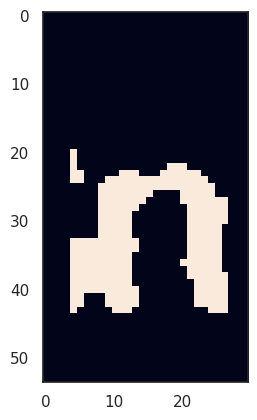

In [14]:
plt.imshow(x[189])
y[189]

Vamos a ver ejemplos de como ha funcionado nuestra división

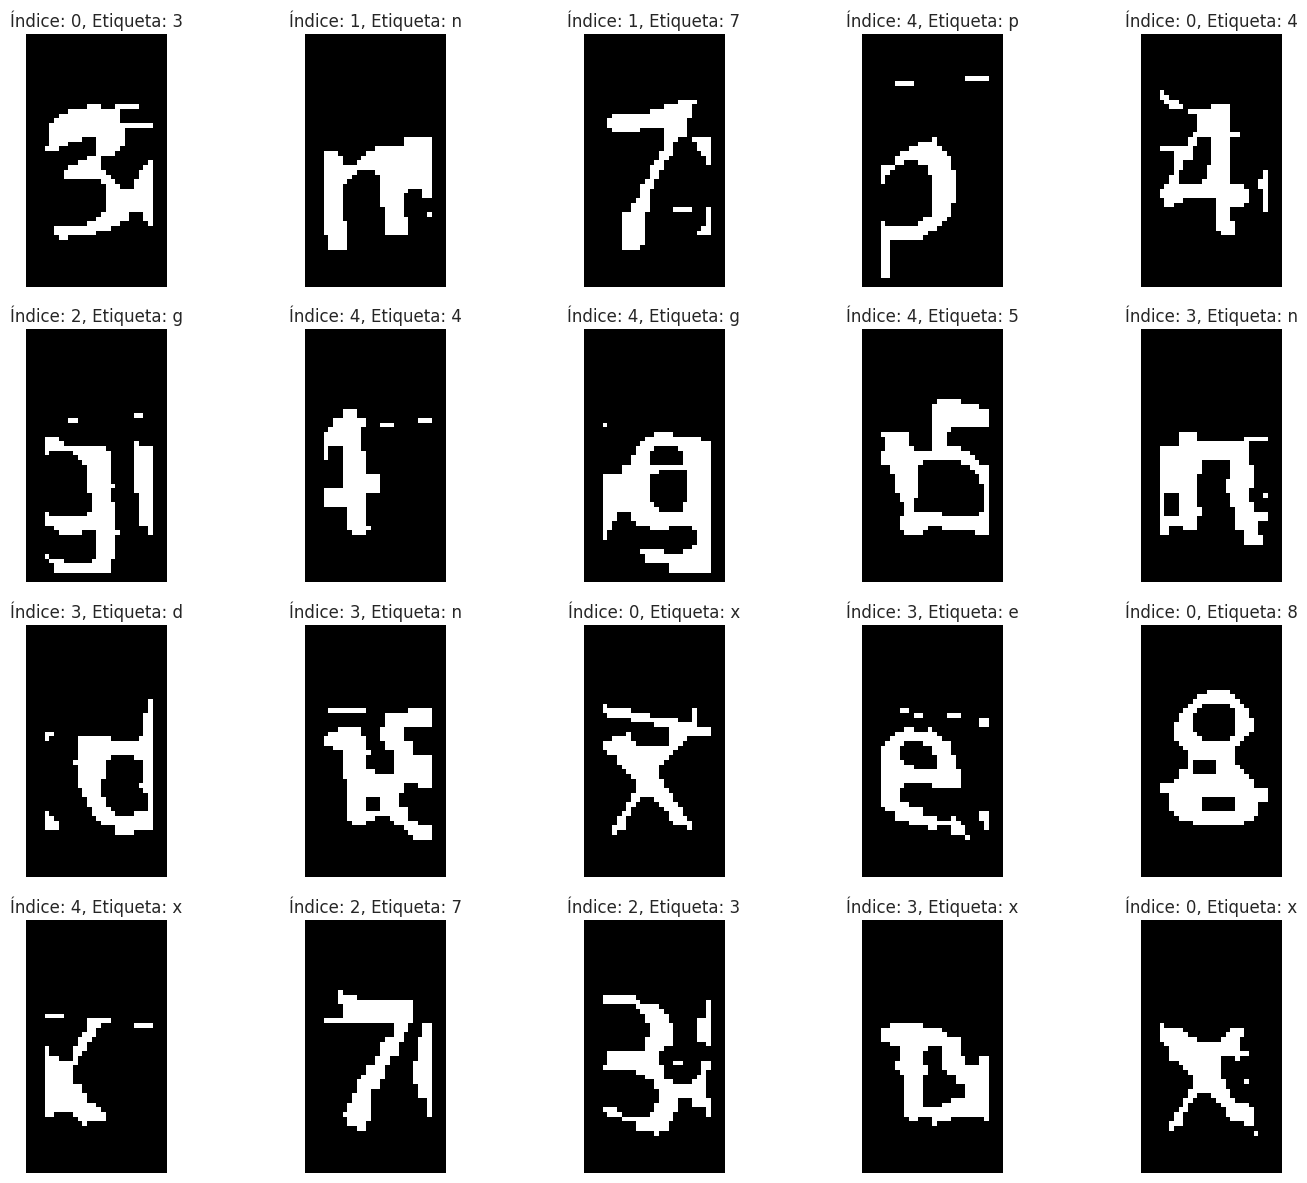

In [15]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Número de ejemplos a mostrar
num_examples = 20

# Genera índices aleatorios para seleccionar ejemplos
random_indices = random.sample(range(len(x)), num_examples)

# Configuración para la disposición de subplots
num_rows = 4  # Cambia esto según la cantidad de filas deseadas
num_cols = 5  # Cambia esto según la cantidad de columnas deseadas

# Crea una figura con subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 12))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    ax.imshow(x[idx], cmap='gray')
    ax.set_title(f'Índice: {idx%5}, Etiqueta: {y[idx]}')
    ax.axis('off')

# Asegura que los subplots vacíos no se muestren
for i in range(num_examples, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()


In [16]:
x=np.array(x)
y=np.array(y)
data=np.reshape(x,(-1,54,30,1))

## One hot encoding

Este código toma una lista de etiquetas categóricas representadas como caracteres y las convierte en una matriz NumPy donde cada etiqueta se representa en formato one-hot encoding. Este formato es útil para entrenar modelos de clasificación multiclase en aprendizaje automático.

In [17]:
train = []
l=['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
for j in y:
    i=l.index(j)
    a=[]
    for r in range(19):
        if(r==i):
            a.append(1)
        else:
            a.append(0)
    a=np.array(a)
    train.append(a)
train=np.array(train)

## Creación del modelo

Convolutional

In [18]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (54,30,1)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(19, activation = "softmax"))

Este código configura el optimizador RMSprop con una tasa de aprendizaje inicial de 0.001, compila el modelo para el entrenamiento de clasificación multiclase, y establece un callback para reducir la tasa de aprendizaje si la precisión en el conjunto de validación no mejora durante un período específico. Esto es útil para ayudar al modelo a converger de manera más eficiente durante el entrenamiento.

In [19]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-08, centered=False)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [20]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

### Separación de datos

Como dijimos antes, los datos estaban desblanceados, con stratify=y, conseguimo sque se dividan de forma que sea estratificada según las etiquetas. Esto es especialmente útil cuando las clases no están igualmente representadas en tu conjunto de datos original.

In [21]:
X_train, X_val, Y_train, Y_val = train_test_split(data, train, test_size = 0.1, random_state= 2, stratify=y)
X_train=X_train/255.0
X_val=X_val/255.0

## Data augmentation

El aumento de datos (data augmentation en inglés) es una técnica ampliamente utilizada en el aprendizaje automático y la visión por computadora, especialmente en tareas de procesamiento de imágenes. Consiste en aplicar transformaciones diversas a los datos de entrenamiento originales para crear nuevas instancias de datos que sean similares a las originales, pero que tengan diferencias menores. El objetivo principal del aumento de datos es enriquecer el conjunto de entrenamiento y mejorar el rendimiento del modelo al aumentar su capacidad de generalización.

In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = False, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

## Fitting

In [23]:
to= time.time()
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs =  30, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
tf = time.time()

print("El tiempo total es: ", tf-to)

Epoch 1/30


<ipython-input-23-a8449c54f74f>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),


53/53 [==============================] - 53s 978ms/step - loss: 2.6920 - accuracy: 0.1578 - val_loss: 1.8385 - val_accuracy: 0.4392 - lr: 0.0010
Epoch 2/30
53/53 [==============================] - 51s 972ms/step - loss: 1.9455 - accuracy: 0.3896 - val_loss: 1.1913 - val_accuracy: 0.7745 - lr: 0.0010
Epoch 3/30
53/53 [==============================] - 52s 984ms/step - loss: 1.3060 - accuracy: 0.5886 - val_loss: 0.6827 - val_accuracy: 0.7863 - lr: 0.0010
Epoch 4/30
53/53 [==============================] - 53s 994ms/step - loss: 0.9556 - accuracy: 0.7066 - val_loss: 0.5584 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 5/30
53/53 [==============================] - 53s 994ms/step - loss: 0.7642 - accuracy: 0.7637 - val_loss: 0.4201 - val_accuracy: 0.8627 - lr: 0.0010
Epoch 6/30
53/53 [==============================] - 52s 977ms/step - loss: 0.6011 - accuracy: 0.8148 - val_loss: 0.3868 - val_accuracy: 0.8588 - lr: 0.0010
Epoch 7/30
53/53 [==============================] - 54s 1s/step - loss: 0.5

Mejor época de entrenamiento: 30, Mejor accuracy de entrenamiento: 0.9591020345687866
Mejor época de validación: 25, Mejor accuracy de validación: 0.9686274528503418


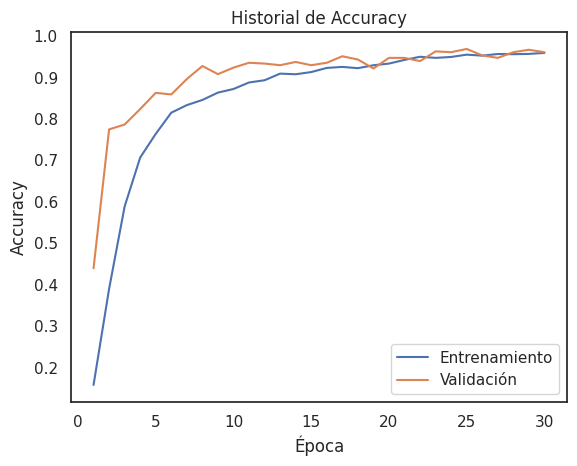

In [24]:
# Obtiene el accuracy de entrenamiento y validación de cada época
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Encuentra la época con el mejor accuracy en el conjunto de entrenamiento y validación
best_epoch_train = train_accuracy.index(max(train_accuracy))
best_accuracy_train = max(train_accuracy)

best_epoch_val = val_accuracy.index(max(val_accuracy))
best_accuracy_val = max(val_accuracy)

# Imprime la época con el mejor accuracy y su valor en entrenamiento y validación
print(f"Mejor época de entrenamiento: {best_epoch_train + 1}, Mejor accuracy de entrenamiento: {best_accuracy_train}")
print(f"Mejor época de validación: {best_epoch_val + 1}, Mejor accuracy de validación: {best_accuracy_val}")

# Grafica el accuracy en el conjunto de entrenamiento y validación a lo largo de las épocas
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Entrenamiento')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validación')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Historial de Accuracy')
plt.show()

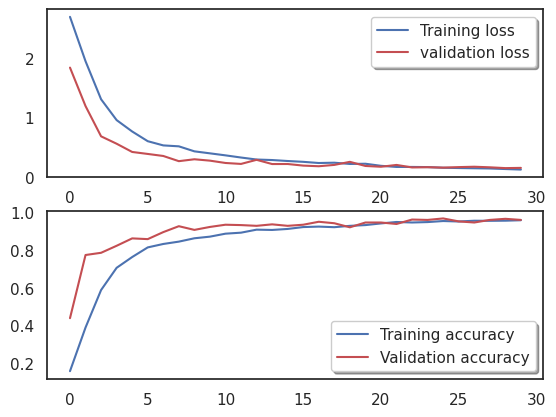

In [25]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Errores detectados

16/16 [==============================] - 2s 107ms/step


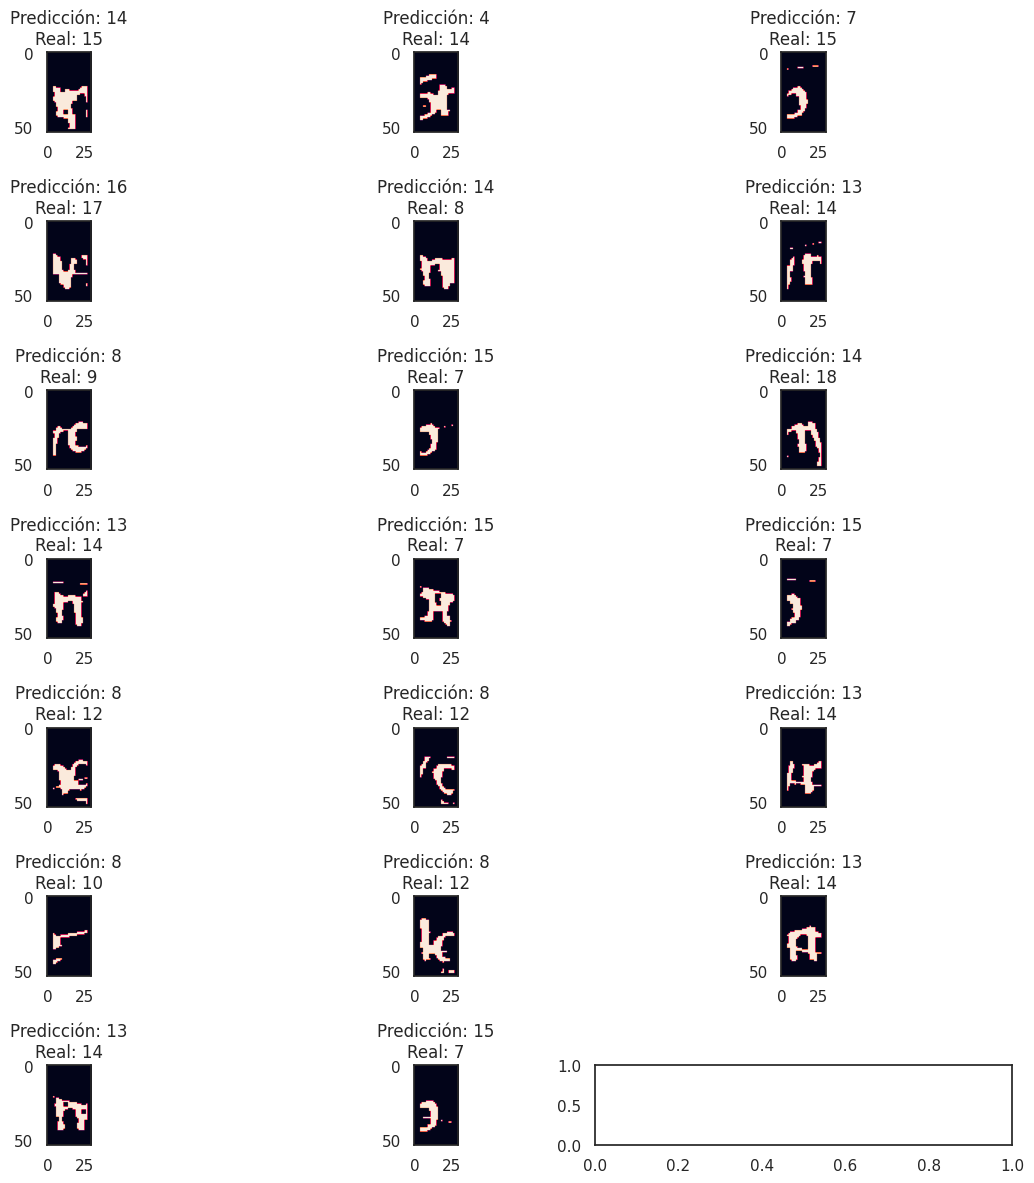

In [26]:
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_all_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ Esta función muestra todas las imágenes con sus etiquetas predichas y reales """
    n = 0
    nrows = (len(errors_index) // 3) + 1
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, figsize=(12, 12))
    for row in range(nrows):
        for col in range(ncols):
            if n < len(errors_index):
                error = errors_index[n]
                ax[row, col].imshow((img_errors[error]).reshape((54, 30)))
                ax[row, col].set_title("Predicción: {}\nReal: {}".format(pred_errors[error], obs_errors[error]))
                n += 1

# Mostrar todos los errores
display_all_errors(range(len(X_val_errors)), X_val_errors, Y_pred_classes_errors, Y_true_errors)
plt.tight_layout()
plt.show()

## Test con captchas completos

Ahora analizaremos en las imagenes completas

In [27]:
def captcha(img,p):
    im=cv2.imread(str(img),0)
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=1)
    images=[]
    for i in range(5):
        images.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
    images=np.reshape(images,(-1,54,30,1))
    pred=model.predict(images)
    pred=np.argmax(pred,axis = 1)
    predicted=str(l[pred[0]]+l[pred[1]]+l[pred[2]]+l[pred[3]]+l[pred[4]])
    if(p):
        print(predicted)
    if(predicted==img[-9:-4]):
        return 1
    return 0


In [28]:
images = list(image_folder.glob("*.png")) + list(image_folder.glob("*.jpg"))
t=0
for i in images:
    t+=captcha(str(i),False)

1/1 [==============================] - 0s 41ms/step


In [29]:
print("total images",len(images),"correctly identified",t)
print("Accuracy is",t/len(images))

total images 1019 correctly identified 923
Accuracy is 0.9057899901864573


In [30]:
pred = model.predict(X_val)

16/16 [==============================] - 1s 81ms/step


In [31]:
pred = np.argmax(pred, axis = 1)
yres = np.argmax(Y_val,axis= 1)

In [32]:
from sklearn.metrics import accuracy_score, classification_report
print('Accuracy : ' + str(accuracy_score(yres, pred)))

Accuracy : 0.9607843137254902


In [33]:
print(classification_report(yres, pred, target_names = l))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        26
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00        27
           6       0.96      1.00      0.98        26
           7       1.00      1.00      1.00        25
           8       1.00      1.00      1.00        26
           b       0.95      0.83      0.89        24
           c       0.84      0.96      0.90        27
           d       1.00      0.96      0.98        25
           e       1.00      0.96      0.98        23
           f       1.00      1.00      1.00        27
           g       1.00      0.89      0.94        27
           m       0.84      1.00      0.92        27
           n       0.94      0.89      0.91        53
           p       0.85      0.92      0.88        25
           w       0.96      1.00      0.98        23
           x       1.00    

# Caracteres faltantes

Para solventar la falta de caracteres en nuestro sejemplos, vamos a incluir un set de caracteres handrwritten con los que tendremos datos de todos los caracteres posibles.

Esto lo usaremos para poder reconocer otro tipo de captchas, ya que para nuestro tipo de captchas, no necesitamos estos nuevos datos

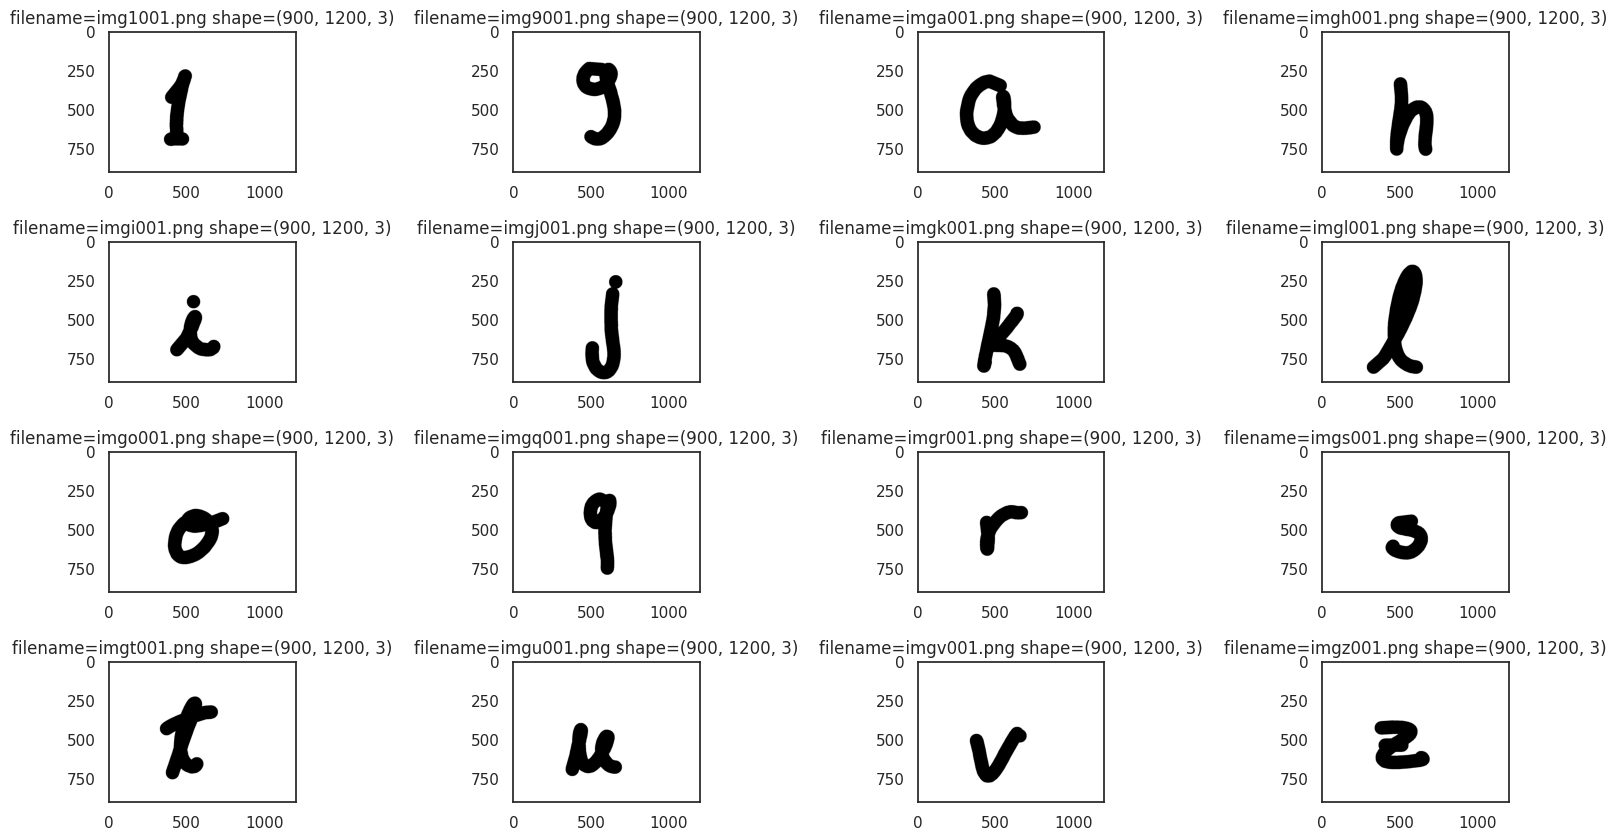

In [50]:
img1001 = mpimg.imread('Faltantes/img1001.png')  # 1
img9001 = mpimg.imread('Faltantes/img9001.png')  # 9
imga001 = mpimg.imread('Faltantes/imga001.png')  # a
imgh001 = mpimg.imread('Faltantes/imgh001.png')  # h
imgi001 = mpimg.imread('Faltantes/imgi001.png')  # i
imgj001 = mpimg.imread('Faltantes/imgj001.png')  # j
imgk001 = mpimg.imread('Faltantes/imgk001.png')  # k
imgl001 = mpimg.imread('Faltantes/imgl001.png')  # l
imgo001 = mpimg.imread('Faltantes/imgo001.png')  # o
imgq001 = mpimg.imread('Faltantes/imgq001.png')  # q
imgr001 = mpimg.imread('Faltantes/imgr001.png')  # r
imgs001 = mpimg.imread('Faltantes/imgs001.png')  # s
imgt001 = mpimg.imread('Faltantes/imgt001.png')  # t
imgu001 = mpimg.imread('Faltantes/imgu001.png')  # u
imgv001 = mpimg.imread('Faltantes/imgv001.png')  # v
imgz001 = mpimg.imread('Faltantes/imgz001.png')  # z

samples = {
    'img1001.png': img1001, 'img9001.png': img9001, 'imga001.png': imga001, 'imgh001.png': imgh001,
    'imgi001.png': imgi001, 'imgj001.png': imgj001, 'imgk001.png': imgk001, 'imgl001.png': imgl001,
    'imgo001.png': imgo001, 'imgq001.png': imgq001, 'imgr001.png': imgr001, 'imgs001.png': imgs001,
    'imgt001.png': imgt001, 'imgu001.png': imgu001, 'imgv001.png': imgv001, 'imgz001.png': imgz001
}

fig = plt.figure(figsize=(20, 10))
pos = 1
for filename, img in samples.items():
    fig.add_subplot(4, 4, pos)
    pos = pos + 1
    plt.imshow(img)
    plt.title('filename=' + filename + ' shape=' + str(img.shape))

# Añadir espacio adicional entre filas
plt.subplots_adjust(hspace=0.5)

plt.show()

En esta estrategia vamos a segmentar las imágenes para poder evaluar caracter por caracter, de esta forma pretendemos entender ...

En esta estrategia, usaremos Keras para generar un modelo OCR (reconocimiento óptico de caracteres). Para facilitar la comprensión de las imágenes, utilizaremos diversos filtros y operaciones a las imágenes, después, se segmentarán las imágenes para entrenar el modelo por caracteres. Más tarde, se utilizarán las imágenes completas para

## One hot encoding


In [82]:
images_1 = list(image_folder.glob("*.png")) + list(image_folder.glob("*.jpg"))

imagenes = []
etiquetas = []
# Iterar a través de la lista de imágenes
for image in images_1:
    # Cargar la imagen en escala de grises (canal único)
    im = cv2.imread(str(image), 0)

    # Aplicar un umbral adaptativo a la imagen utilizando el método GAUSSIAN_C
    threshold = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 5)

    # Dilatar la imagen umbralizada utilizando un kernel definido en algún lugar anterior del código
    erosion = cv2.dilate(threshold, kernel, iterations=1)

    # Obtener el nombre de archivo de la imagen
    s = str(image)

    # Dividir la imagen erosionada en 5 partes iguales y procesar cada parte con la función 'pad'
    for i in range(5):
        # Agregar la imagen procesada a la lista 'x'
        imagenes.append(pad(erosion[:, (30 + 23 * i):(30 + 23 * (i + 1))]))

        # Agregar la etiqueta correspondiente (carácter o dígito) a la lista 'y'
        etiquetas.append(s[-9 + i])

ruta_carpeta = "/content/Faltantes"
for archivo in os.listdir(ruta_carpeta):
  if archivo.endswith(".png") or archivo.endswith(".jpg"):
    # Extraer etiqueta del nombre del archivo
    etiqueta = archivo[3]

    # Cargar la imagen y convertirla a escala de grises
    ruta_completa = os.path.join(ruta_carpeta, archivo)
    imagen = cv2.imread(ruta_completa, cv2.IMREAD_GRAYSCALE)

    # Recortamos la imagen para quitar informacion irrelevante
    inicio_x, final_x = 300, 850
    inicio_y, final_y = 150, 800

    # Realizar el recorte
    imagen_recortada = imagen[inicio_y:final_y, inicio_x:final_x]

    # Añadir la imagen y la etiqueta a las listas
    imagenes.append(imagen_recortada)
    etiquetas.append(etiqueta)

# Resizeamos las imagenes para que tengan la misma forma que las demas: (54,30)
nuevas_imagenes = []

for imagen in imagenes:
    # Redimensionar la imagen
    nueva_imagen = cv2.resize(imagen, (30, 54))  # el formato es (ancho, alto)
    nuevas_imagenes.append(nueva_imagen)

# Convertir a matrices numpy
imagenes = np.array(nuevas_imagenes)
etiquetas = np.array(etiquetas)
# Realizar one-hot encoding utilizando LabelBinarizer
lb = LabelBinarizer()
etiquetas_encoded = lb.fit_transform(etiquetas)

In [83]:
print("Forma de la imagen en la posición 5500:", imagenes[5500].shape)


Forma de la imagen en la posición 5500: (54, 30)


In [84]:
print("Forma de la imagen en la posición 1:", imagenes[1].shape)


Forma de la imagen en la posición 1: (54, 30)


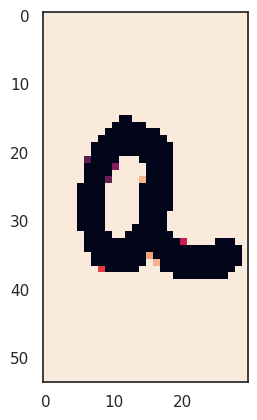

In [85]:
plt.imshow(imagenes[5500])

In [86]:
# # Supongamos que imagenes[5500] es la imagen que deseas recortar
# imagen_original = imagenes[5500]

# # Definir las coordenadas para el recorte
# inicio_x, final_x = 300, 850
# inicio_y, final_y = 150, 800

# # Realizar el recorte
# imagen_recortada = imagen_original[inicio_y:final_y, inicio_x:final_x]

# # Visualizar la imagen recortada
# plt.imshow(imagen_recortada, cmap='gray')
# plt.show()


In [87]:
print(lb.classes_)

['1' '2' '3' '4' '5' '6' '7' '8' '9' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i'
 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


AttributeError: ignored

In [150]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (54,30,1)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(35, activation = "softmax"))

In [124]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [151]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-08, centered=False)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### Separación de datos

In [152]:
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(imagenes, etiquetas_encoded, test_size = 0.1, random_state= 2, stratify=etiquetas)
X_train2=X_train2/255.0
X_val2=X_val2/255.0

## Data augmentation

In [153]:
print("Forma de X_train2:", X_train2.shape)

Forma de X_train2: (5377, 54, 30)


In [154]:
import numpy as np

# Añadir una dimensión para el canal de color (escala de grises)
X_train2 = np.expand_dims(X_train2, axis=-1)
X_val2 = np.expand_dims(X_val2, axis=-1)

#Verificar la nueva forma de X_train2
print("Nueva forma de X_train2:", X_train2.shape)


Nueva forma de X_train2: (5377, 54, 30, 1)


In [155]:
print("Nueva forma de X_train2:", X_val2.shape)

Nueva forma de X_train2: (598, 54, 30, 1)


In [156]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = False, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train2)

## Fitting

In [157]:
to= time.time()
history = model.fit(datagen.flow(X_train2,Y_train2, batch_size=86),
                              epochs =  30, validation_data = (X_val2,Y_val2),
                              verbose = 1, steps_per_epoch=X_train2.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
tf = time.time()

print("El tiempo total es: ", tf-to)

Epoch 1/30
62/62 [==============================] - 60s 948ms/step - loss: 2.9393 - accuracy: 0.1503 - val_loss: 1.6374 - val_accuracy: 0.4582 - lr: 0.0010
Epoch 2/30
62/62 [==============================] - 60s 962ms/step - loss: 1.8588 - accuracy: 0.4137 - val_loss: 1.1051 - val_accuracy: 0.6639 - lr: 0.0010
Epoch 3/30
62/62 [==============================] - 59s 945ms/step - loss: 1.4522 - accuracy: 0.5481 - val_loss: 0.8692 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 4/30
62/62 [==============================] - 58s 944ms/step - loss: 1.1883 - accuracy: 0.6341 - val_loss: 0.6561 - val_accuracy: 0.7926 - lr: 0.0010
Epoch 5/30
62/62 [==============================] - 60s 964ms/step - loss: 0.9929 - accuracy: 0.6893 - val_loss: 0.6083 - val_accuracy: 0.7943 - lr: 0.0010
Epoch 6/30
62/62 [==============================] - 60s 953ms/step - loss: 0.8608 - accuracy: 0.7169 - val_loss: 0.5616 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 7/30
62/62 [==============================] - 58s 943ms/st